In [1]:
import pickle

import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
import sys
import os
import time

In [4]:
from OpenData import *

In [5]:
pkl_dict = unpickle('cifar-10-batches-py/data_batch_1')
labels=pkl_dict['labels']
images=pkl_dict['data']
labels = np.array(labels,dtype=np.uint8)
images = images / np.float32(256)
X_train = images.reshape((10000,3,32,32))
y_train = labels
for i in ('2','3','4','5'):
    pkl_dict = unpickle('cifar-10-batches-py/data_batch_'+i)
    labels=pkl_dict['labels']
    images=pkl_dict['data']
    labels = np.array(labels,dtype=np.uint8)
    images = images / np.float32(256)
    X_train = np.vstack((X_train,images.reshape((10000,3,32,32))))
    y_train = np.concatenate((y_train,labels))

In [6]:
pkl_dict = unpickle('cifar-10-batches-py/test_batch')
labels=pkl_dict['labels']
images=pkl_dict['data']
labels = np.array(labels,dtype=np.uint8)
images = images / np.float32(256)
X_test = images.reshape((10000,3,32,32))
y_test = labels

In [7]:
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=128,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Создаём нейросеть

In [9]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

In [10]:
network = build_cnn(input_var)

In [11]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

In [12]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                        dtype=theano.config.floatX)

In [13]:
pred = test_prediction.argmax(-1)
f_predict = theano.function([input_var], pred)

In [14]:
train_fn = theano.function([input_var, target_var], 
                           loss, 
                           updates=updates,
                           allow_input_downcast=True)

val_fn = theano.function([input_var, target_var], 
                         [test_loss, test_acc],
                         allow_input_downcast=True)

## Обучаем модель

In [15]:
num_epochs = 100

In [16]:
BATCH_SIZE = 128

In [17]:
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, BATCH_SIZE, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
        
    print("Epoch: {}, train:{}, val:{}".format(epoch, 
                                               train_err/train_batches,
                                               val_err/val_batches))

Epoch: 0, train:1.86780186066, val:1.50963816582
Epoch: 1, train:1.51530777858, val:1.34586921105
Epoch: 2, train:1.40261604113, val:1.23958225739
Epoch: 3, train:1.33646761974, val:1.1915694735
Epoch: 4, train:1.2829907726, val:1.16200206524
Epoch: 5, train:1.24007082566, val:1.12681570726
Epoch: 6, train:1.20555530099, val:1.11443859568
Epoch: 7, train:1.1731649949, val:1.08059808383
Epoch: 8, train:1.14210055669, val:1.06871143518
Epoch: 9, train:1.10715897206, val:1.02440994443
Epoch: 10, train:1.08260856821, val:1.01819005838
Epoch: 11, train:1.05666936116, val:0.995589444271
Epoch: 12, train:1.03959606397, val:0.992933783012
Epoch: 13, train:1.01167870959, val:1.01548630916
Epoch: 14, train:0.994936350523, val:0.974448066491
Epoch: 15, train:0.981762475845, val:0.988118115144
Epoch: 16, train:0.960482538358, val:0.950421633629
Epoch: 17, train:0.9443082947, val:0.935250180654
Epoch: 18, train:0.93046308007, val:0.934849265294
Epoch: 19, train:0.916715347767, val:0.935933363743
Ep

# Обрабатываем оставшиеся изображении

In [18]:
y_true = []
y_pred = []
test_size=10000
for i in range(test_size):
    y_true.append(int(y_test[i]))
    y_pred.append(f_predict([X_test[i]])[0])

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
CM = confusion_matrix(y_true, y_pred)

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


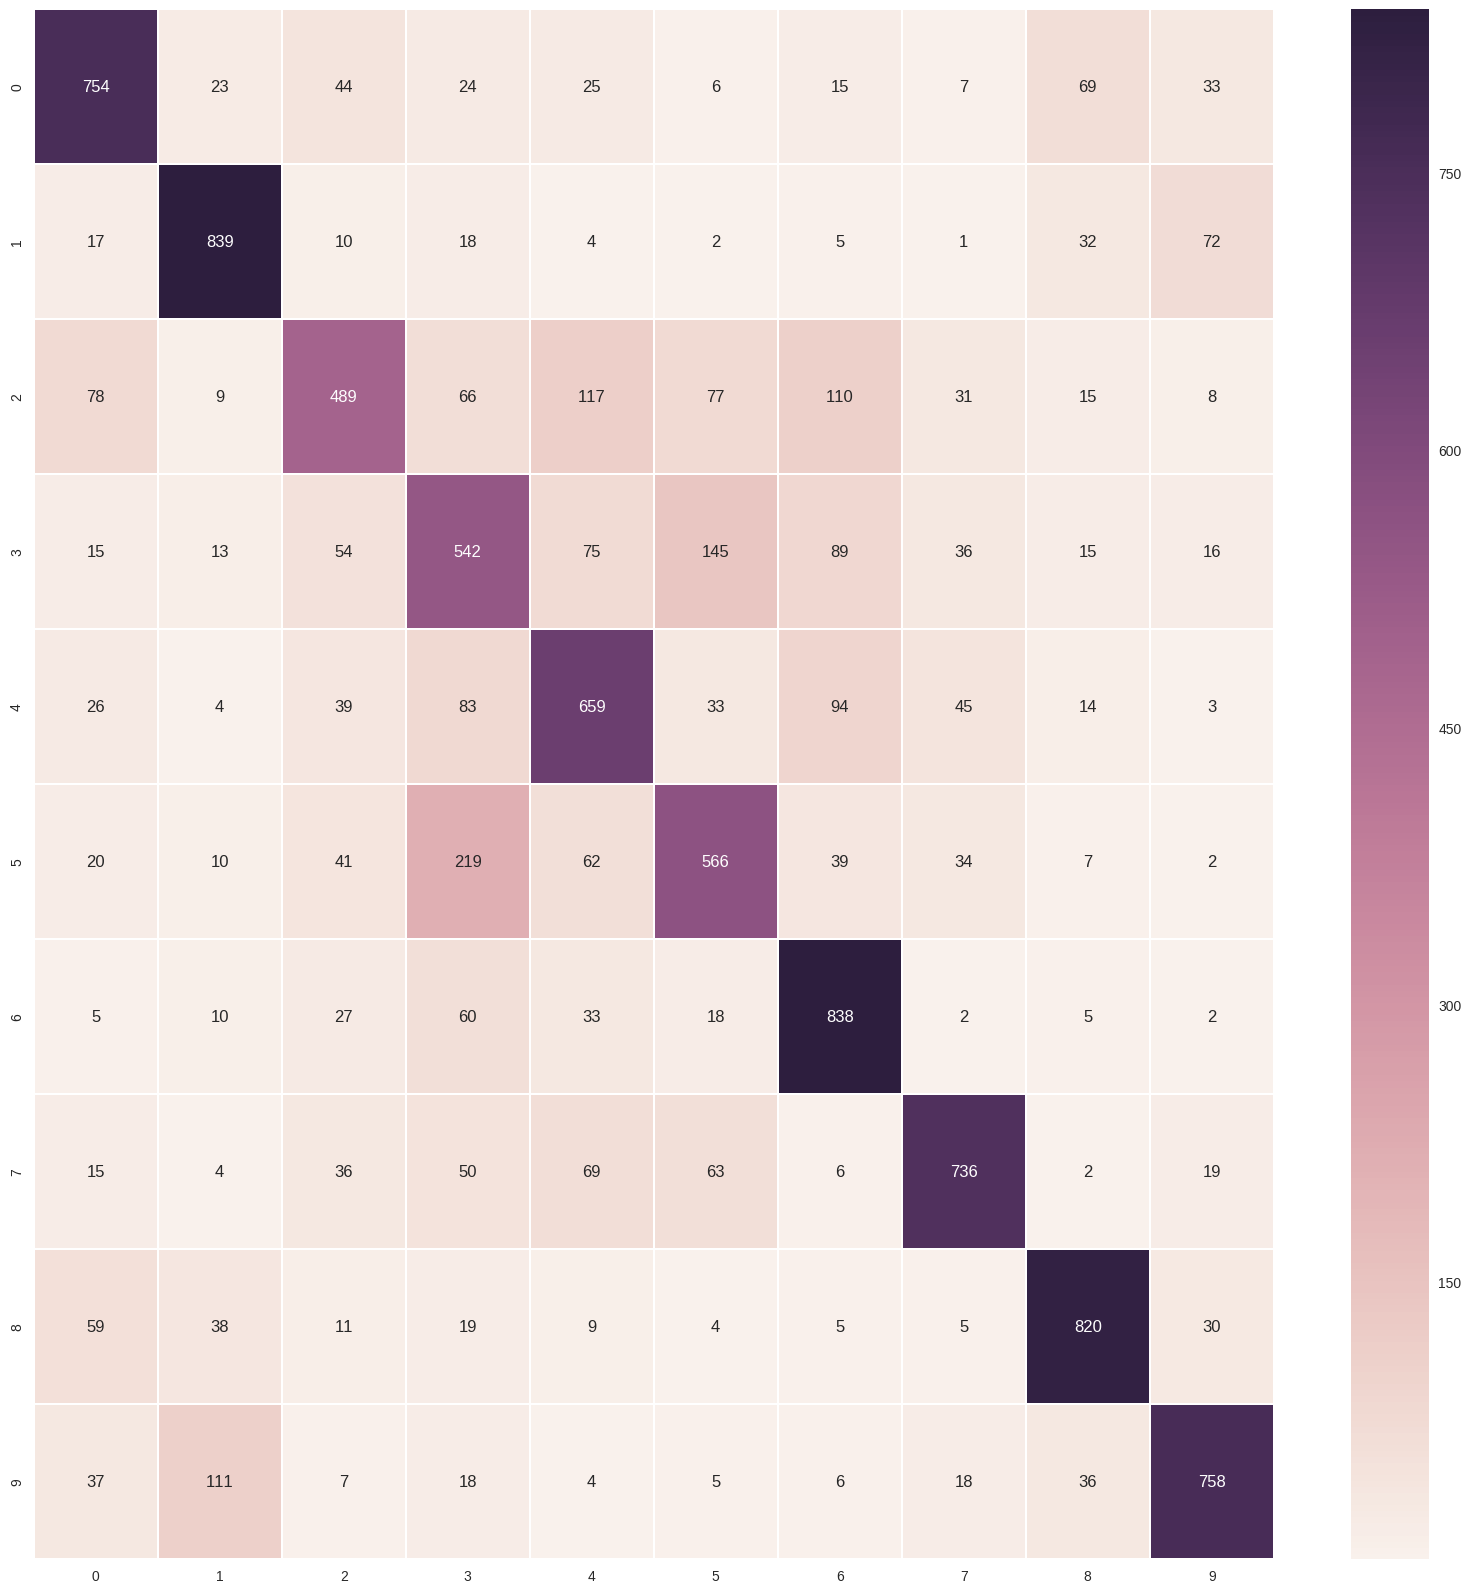

In [21]:
import seaborn as sns

fig = plt.figure(figsize=(20, 20))
sns.heatmap(CM, annot=True, fmt="d", linewidths=.5)
plt.show()

In [22]:
from sklearn.metrics import classification_report
target_names = ['class'+str(i) for i in range(0,10)]
print(classification_report(y_true, y_pred, target_names=target_names))


             precision    recall  f1-score   support

     class0       0.73      0.75      0.74      1000
     class1       0.79      0.84      0.81      1000
     class2       0.65      0.49      0.56      1000
     class3       0.49      0.54      0.52      1000
     class4       0.62      0.66      0.64      1000
     class5       0.62      0.57      0.59      1000
     class6       0.69      0.84      0.76      1000
     class7       0.80      0.74      0.77      1000
     class8       0.81      0.82      0.81      1000
     class9       0.80      0.76      0.78      1000

avg / total       0.70      0.70      0.70     10000

